In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from symbols import syntax_tree

In [2]:
SAMPLE_SIZE = 200
NOISE       = 0.0

POPSIZE         = 100
MAX_STREE_DEPTH = 5
GENERATIONS     = 50
GROUP_SIZE      = 5  # tournament selector.
MUTATION_RATE   = 0.15
ELITISM         = 1

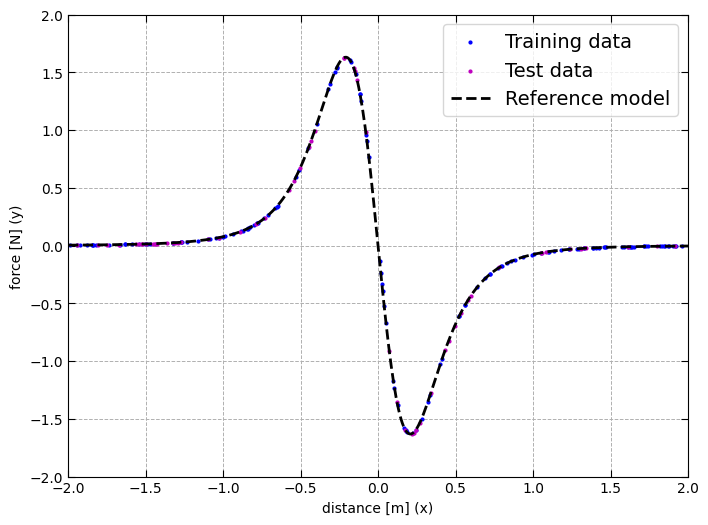

In [3]:
S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=0.7)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [ ]:
syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp_creator.RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

#evaluator = gp.R2Evaluator(S_train)
#evaluator = gp.FUEvaluator(S_train, S.knowledge)
#evaluator = gp.NumericalFUEvaluator(S_train, S.knowledge)
evaluator = gp_evaluator.FastFUEvaluator(S_train, S.knowledge)

selector = gp_selector.TournamentSelector(GROUP_SIZE)

crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH)
#crossover = gp_crossover.ApproxGeometricCrossover(lib, MAX_STREE_DEPTH, diversifier)
#crossover = gp_crossover.CrossNPushCrossover(lib, MAX_STREE_DEPTH)
#crossover = gp_crossover.ConstrainedCrossNPushCrossover(lib, MAX_STREE_DEPTH, evaluator.know_evaluator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

with np.errstate(all='ignore'):
      import profiling

      with tqdm(total=symb_regressor.ngen-1) as pbar:
            def on_newgen(genidx, status):
                  pbar.update(1)
                  pbar.set_description(status)
            best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)
      
      profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")

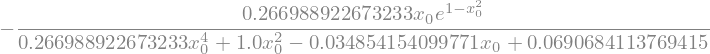

In [5]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

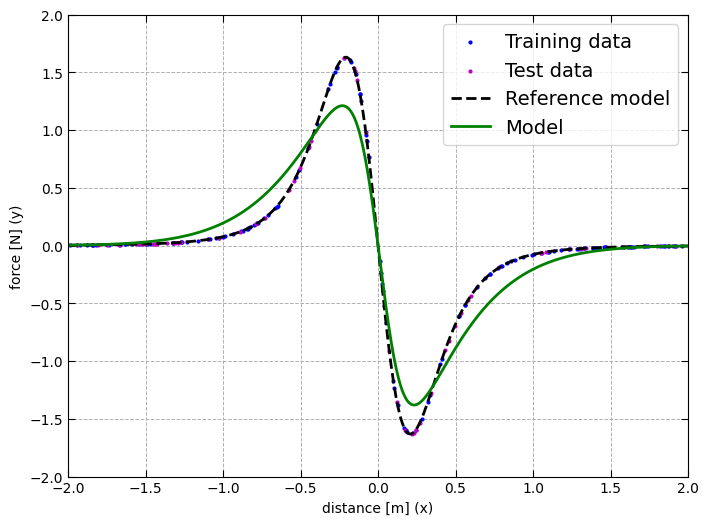

In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)

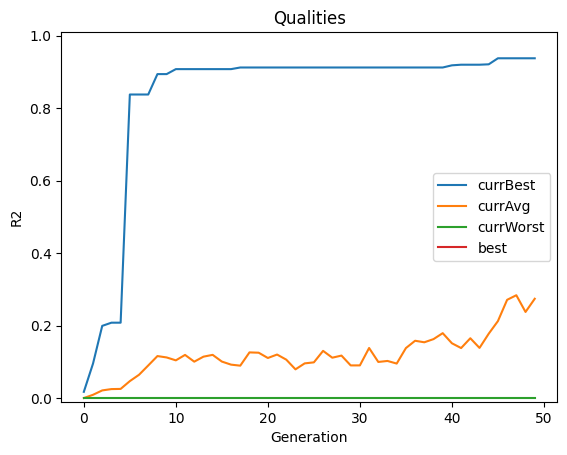

In [7]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

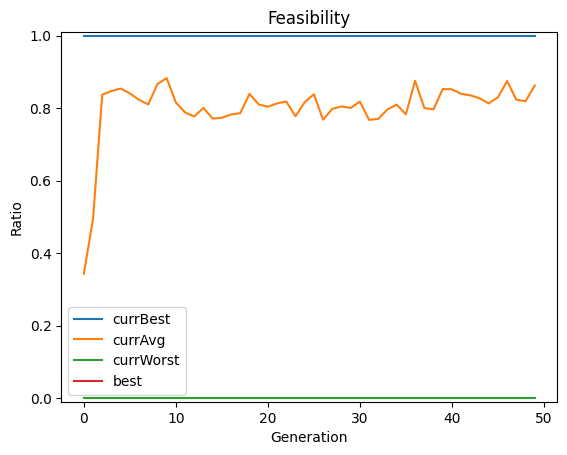

In [8]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

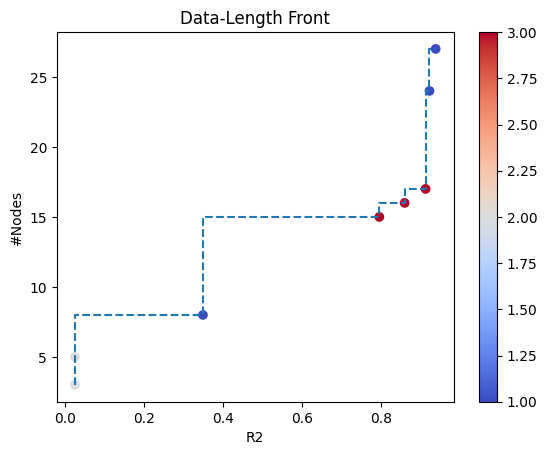

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,((exp((x0 / x0)) / (((0.17 * 0.75) - (0.26 / x...,0,0.034734,0.937814,27,"(/, +, cube, *, exp, square)",1,inf
1,1,(-0.08 * x0),0,0.008252,0.024757,3,(),2,inf
2,2,((-0.24 * x0) * square(log(square(x0)))),0,0.043598,0.348782,8,"(log, *, square)",1,1.260507
3,3,(square(log(square(x0))) * (x0 / ((x0 - exp(0....,0,0.053021,0.795312,15,"(/, +, *, square, exp, log)",3,0.892456
4,4,(-0.09 * (0.96 * x0)),0,0.004968,0.024838,5,(),2,0.563213
5,5,((exp((x0 / x0)) / ((0.75 - (0.26 / x0)) - (0....,0,0.038423,0.922162,24,"(/, +, *, exp, square)",1,0.444522
6,6,(square(log(square(x0))) * (x0 / (((-0.34 + -0...,0,0.053669,0.912380,17,"(/, +, *, square, exp, log)",3,0.402190
7,7,(square(log(square(x0))) * (x0 / (((-1.94 + x0...,0,0.053706,0.859292,16,"(/, +, *, square, exp, log)",3,0.211549
8,0,(-0.08 * (x0 / 0.95)),1,0.004968,0.024838,5,(),1,inf
9,1,((exp((x0 / x0)) / (((0.17 * 0.75) - (0.27 / x...,1,0.034534,0.932430,27,"(/, +, cube, *, exp, square)",2,inf


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)